## Bayes' Theorem Calculator

Whenever you are using a test to determine if something is happening or not, it is time to use Bayes' theorem to avoid comitting the base rate fallacy. However, the mathematical notation and formula may be intimidating. You can use the following calculator to learn how Bayes' theorem works, and to answer practical questions about probability.

Run the following box by clicking on it and pressing `Shift+Return`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython import display
%matplotlib widget

In [2]:
total = 1000
ny = 25
c_pos = '#ffa600' # yellow orange
c_neg = '#003f5c' # dark blue
c_pos_dim = '#ffe4b3'
c_neg_dim = '#b3e7ff'

xs = np.arange(total) // ny
ys = np.arange(total) % ny

p_pos = 0.5
p_false_pos = 0.1
p_false_neg = 0.1

highlight_pos = True
highlight_neg = True

def ppv():
    true_pos = p_pos * (1 - p_false_neg)
    false_pos = (1 - p_pos) * p_false_pos
    return true_pos / (true_pos + false_pos)

def npv():
    true_neg = (1 - p_pos) * (1 - p_false_pos)
    false_neg = p_pos * p_false_neg
    return true_neg / (true_neg + false_neg)

@np.vectorize
def c_map(pos, dim):
    return (c_pos_dim if pos else c_neg_dim) if dim else (c_pos if pos else c_neg)

def truth_and_test(p_pos, p_false_pos, p_false_neg):
    arr = np.zeros((2, total))
    n_pos = int(total * p_pos)
    n_false_pos = int(total * (1 - p_pos) * p_false_pos)
    n_false_neg = int(total * p_pos * p_false_neg)
    arr[:,:n_pos] = 1 # the truth
    arr[1,total-n_false_pos:] = 1 # the test result
    arr[1,:n_false_neg] = 0
    return arr

def plot(output, ax, ppv_label, npv_label):
    ppv_label.value = f'Probability of true positive given positive test: {ppv()*100:.1f}%'
    npv_label.value = f'Probability of true negative given negative test: {npv()*100:.1f}%'
    truth_and_test_results = truth_and_test(p_pos, p_false_pos, p_false_neg)
    dim = (1 - truth_and_test_results[1]) * (not highlight_pos) + truth_and_test_results[1] * (not highlight_neg)
    c_fill = c_map(truth_and_test_results[0], dim)
    c_edge = c_map(truth_and_test_results[1], dim)
    ax.clear()
    ax.scatter(xs, ys, s=50, c=c_fill, edgecolors=c_edge, linewidth=1.5)

def update_p_pos(output, ax, ppv_label, npv_label):
    def f(change):
        global p_pos
        p_pos = change['new'] / 100
        plot(output, ax, ppv_label, npv_label)
    return f

def update_p_false_pos(output, ax, ppv_label, npv_label):
    def f(change):
        global p_false_pos
        p_false_pos = change['new'] / 100
        plot(output, ax, ppv_label, npv_label)
    return f

def update_p_false_neg(output, ax, ppv_label, npv_label):
    def f(change):
        global p_false_neg
        p_false_neg = change['new'] / 100
        plot(output, ax, ppv_label, npv_label)
    return f

def update_highlight_pos(output, ax, ppv_label, npv_label):
    def f(change):
        global highlight_pos
        highlight_pos = not highlight_pos
        plot(output, ax, ppv_label, npv_label)
    return f

def update_highlight_neg(output, ax, ppv_label, npv_label):
    def f(change):
        global highlight_neg
        highlight_neg = not highlight_neg
        plot(output, ax, ppv_label, npv_label)
    return f

FloatSlider(value=50.0, description='Prior probability', layout=Layout(width='400px'), readout_format='.1f', s…

FloatSlider(value=10.0, description='False positive rate', layout=Layout(width='400px'), readout_format='.1f',…

FloatSlider(value=10.0, description='False negative rate', layout=Layout(width='400px'), readout_format='.1f',…

Output()

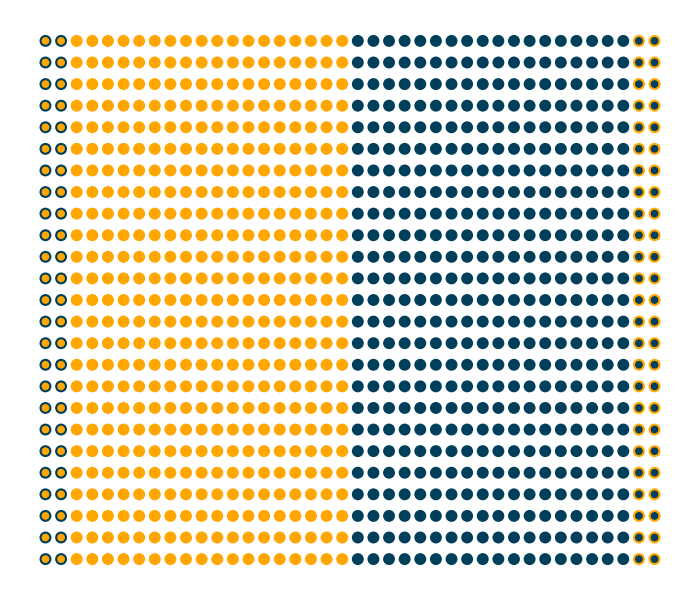

In [3]:
q1_label = widgets.Label(value='What is the question you are trying to answer?')
q1_text = widgets.Text(placeholder='e.g. Do I have Covid? Is Jack the Killer?')
q2_label = widgets.Label(value='What is the test you are performing?')
q2_text = widgets.Text(placeholder='e.g. PCR test')
run_button = widgets.Button(description='Update demo')
questions_hbox = widgets.HBox([
    widgets.VBox([q1_label, q1_text]),
    widgets.VBox([q2_label, q2_text]),
    run_button
], layout={'display': 'flex', 'align_items': 'flex-end'})
p_pos_slider = widgets.FloatSlider(value=50, min=0, max=100, step=0.1, description='Prior probability', readout=True, readout_format='.1f', layout={'width': '400px'}, style={'description_width': '150px'})
p_false_pos_slider = widgets.FloatSlider(value=10, min=0, max=100, step=0.1, description='False positive rate', readout=True, readout_format='.1f', layout={'width': '400px'}, style={'description_width': '150px'})
p_false_neg_slider = widgets.FloatSlider(value=10, min=0, max=100, step=0.1, description='False negative rate', readout=True, readout_format='.1f', layout={'width': '400px'}, style={'description_width': '150px'})
ppv_label = widgets.Label(value='')
npv_label = widgets.Label(value='')
highlight_pos_toggle = widgets.ToggleButton(value=True, description='Show positive tests')
highlight_neg_toggle = widgets.ToggleButton(value=True, description='Show negative tests')
ppv_hbox = widgets.HBox([highlight_pos_toggle, ppv_label])
npv_hbox = widgets.HBox([highlight_neg_toggle, npv_label])
output = widgets.Output()

plt.rc('axes.spines', top=False, bottom=False, left=False, right=False)
fig, ax = plt.subplots(figsize=(7, 6))
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plot(output, ax, ppv_label, npv_label)
plt.tight_layout()
# run_button.on_click(plot(output, ax))
p_pos_slider.observe(update_p_pos(output, ax, ppv_label, npv_label), names='value')
p_false_pos_slider.observe(update_p_false_pos(output, ax, ppv_label, npv_label), names='value')
p_false_neg_slider.observe(update_p_false_neg(output, ax, ppv_label, npv_label), names='value')
highlight_pos_toggle.observe(update_highlight_pos(output, ax, ppv_label, npv_label), names='value')
highlight_neg_toggle.observe(update_highlight_neg(output, ax, ppv_label, npv_label), names='value')

display.display(questions_hbox, p_pos_slider, p_false_pos_slider, p_false_neg_slider, ppv_hbox, npv_hbox, output)